In [3]:
# Cargue de Librerías básicas
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Importar tensorflow
import tensorflow as tf
print("TF version   : ", tf.__version__)

# Necesitaremos GPU
print("GPU available: ", tf.config.list_physical_devices('GPU'))

# keras version is 2.11.0
import keras
print("Keras version   : ", keras.__version__)



TF version   :  2.15.0
GPU available:  []
Keras version   :  2.15.0


In [4]:
#--------------------------------------------#
#       debido a que estoy usando COLAB      #
#--------------------------------------------#

from google.colab import drive
drive.mount('/content/drive') #/content/drive/MyDrive/pec2/data/xl.pickle
print("GPU available: ", tf.config.list_physical_devices('GPU'))

Mounted at /content/drive
GPU available:  []


In [5]:
import pandas as pd

home =  '/content/drive/MyDrive/TFM/'

file_path = home + "2017_2023DSTrabajo.xlsx"

dsXls = pd.read_excel(file_path)
dsXls.head(5)
dsXls.info()

####################################
# LIMPIEZA DE DATOS
####################################
#1. validar duplicados
dsXls.nunique()

#2. validar nulos, rellenar valores faltantes con la mediana
dsXls['Dist'].fillna(dsXls['Dist'].median(), inplace=True)
dsXls['Attendance'].fillna(dsXls['Attendance'].median(), inplace=True)
dsXls.isnull().sum()


####################################
# ESTADISTICAS
####################################
#dsXls.describe().T
dsXls.iloc[:,1:].describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4092 entries, 0 to 4091
Data columns (total 21 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Date        4092 non-null   datetime64[ns]
 1   Round       4092 non-null   object        
 2   Day         4092 non-null   object        
 3   Venue       4092 non-null   object        
 4   Result      4092 non-null   object        
 5   GF          4092 non-null   float64       
 6   GA          4092 non-null   float64       
 7   Opponent    4092 non-null   object        
 8   xG          4092 non-null   float64       
 9   xGA         4092 non-null   float64       
 10  Poss        4092 non-null   float64       
 11  Attendance  3212 non-null   float64       
 12  Season      4092 non-null   int64         
 13  Team        4092 non-null   object        
 14  Sh          4092 non-null   float64       
 15  SoT         4092 non-null   float64       
 16  Dist        4089 non-nul

,GF,GA,xG,xGA,Poss,Attendance,Season,Sh,SoT,Dist,SCA,KP,PPA,CrsPA
count,4092.000000,4092.000000,4092.000000,4092.000000,4092.000000,4092.000000,4092.000000,4092.000000,4092.000000,4092.000000,4092.000000,4092.000000,4092.000000,4092.000000
mean,1.377810,1.377810,1.346163,1.346163,50.001222,36912.650049,2019.214076,12.317693,4.102884,17.675318,21.840176,9.215054,7.901760,1.869501
std,1.277631,1.277631,0.796551,0.796551,12.726702,15301.262664,1.566615,5.427259,2.437269,3.038064,9.897661,4.401972,4.553291,1.613642
min,0.000000,0.000000,0.000000,0.000000,18.000000,2000.000000,2017.000000,0.000000,0.000000,5.300000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.700000,0.700000,41.000000,29296.000000,2018.000000,8.000000,2.000000,15.700000,14.000000,6.000000,5.000000,1.000000
50%,1.000000,1.000000,1.200000,1.200000,50.000000,32092.500000,2019.000000,12.000000,4.000000,17.600000,21.000000,9.000000,7.000000,2.000000
75%,2.000000,2.000000,1.800000,1.800000,59.000000,51237.000000,2021.000000,16.000000,6.000000,19.500000,28.000000,12.000000,10.000000,3.000000
max,9.000000,9.000000,5.900000,5.900000,82.000000,83222.000000,2022.000000,36.000000,15.000000,35.000000,66.000000,34.000000,33.000000,12.000000


In [6]:
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping


# Cargar los datos
data = dsXls

# Asegurarse de que todas las columnas numéricas estén en el tipo de dato correcto
data['Attendance'] = pd.to_numeric(data['Attendance'], errors='coerce')
data['Dist'] = pd.to_numeric(data['Dist'], errors='coerce')

# Imputar valores faltantes
data['Attendance'].fillna(data['Attendance'].median(), inplace=True)
data['Dist'].fillna(data['Dist'].median(), inplace=True)

# Convertir columnas de tipo string a variables numéricas usando Label Encoding
le = LabelEncoder()

# Separar características y variable objetivo. 'Date', 'Round', 'Day', 'Venue', 'Result', 'Team', 'Opponent'
X = data.drop(['Date', 'Round', 'Day', 'Venue', 'Result', 'Team', 'Opponent'], axis=1) #X = data.drop('Result', axis=1)
y = le.fit_transform(data['Result'])

# Asegurarse de que todas las características estén en el tipo de dato correcto
X = X.apply(pd.to_numeric)

# Estandarizar las características
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Aplicar PCA
pca = PCA(n_components=0.95)  # Retener el 95% de la varianza
X_pca = pca.fit_transform(X_scaled)

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

# Convertir y_train y y_test a categorías
y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)

# Definir la red neuronal con regularización y dropout
model = Sequential()
model.add(Dense(128, input_dim=X_pca.shape[1], activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.5))
model.add(Dense(y_train.shape[1], activation='softmax'))

# Compilar el modelo
model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])

# Añadir EarlyStopping para evitar sobreentrenamiento
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Entrenar el modelo
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

# Evaluar el modelo
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Precisión del modelo: {accuracy:.2f}')

Epoch 1/100
82/82 [==============================] - 1s 5ms/step - loss: 1.7295 - accuracy: 0.6173 - val_loss: 1.2436 - val_accuracy: 0.8122
Epoch 2/100
82/82 [==============================] - 0s 3ms/step - loss: 1.1550 - accuracy: 0.7655 - val_loss: 0.8640 - val_accuracy: 0.8748
Epoch 3/100
82/82 [==============================] - 0s 3ms/step - loss: 0.8542 - accuracy: 0.8323 - val_loss: 0.6704 - val_accuracy: 0.9008
Epoch 4/100
82/82 [==============================] - 0s 3ms/step - loss: 0.6704 - accuracy: 0.8667 - val_loss: 0.5425 - val_accuracy: 0.9237
Epoch 5/100
82/82 [==============================] - 0s 3ms/step - loss: 0.5576 - accuracy: 0.8950 - val_loss: 0.4587 - val_accuracy: 0.9359
Epoch 6/100
82/82 [==============================] - 0s 3ms/step - loss: 0.4851 - accuracy: 0.8980 - val_loss: 0.4030 - val_accuracy: 0.9298
Epoch 7/100
82/82 [==============================] - 0s 3ms/step - loss: 0.4239 - accuracy: 0.9148 - val_loss: 0.3644 - val_accuracy: 0.9344
Epoch 8/100
8

26/26 [==============================] - 0s 2ms/step - loss: 0.2197 - accuracy: 0.9353
Precisión del modelo: 0.94
26/26 [==============================] - 0s 1ms/step
Matriz de Confusión:
[[165  13   7]
 [ 10 278   1]
 [ 22   0 323]]


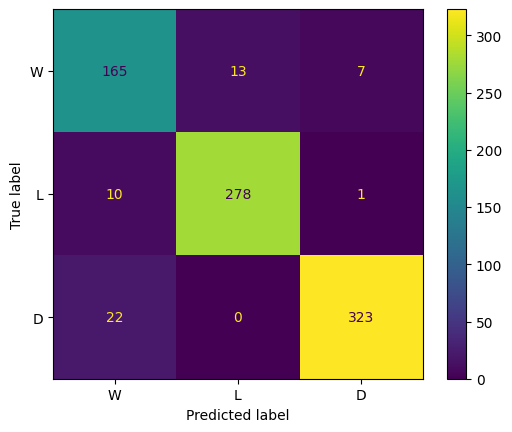

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.84      0.89      0.86       185
           1       0.96      0.96      0.96       289
           2       0.98      0.94      0.96       345

    accuracy                           0.94       819
   macro avg       0.92      0.93      0.93       819
weighted avg       0.94      0.94      0.94       819



In [7]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score
import numpy as np

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
#from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.regularizers import l2

# Evaluar el modelo
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Precisión del modelo: {accuracy:.2f}')

# Obtener predicciones
y_pred_cat = model.predict(X_test)
y_pred = np.argmax(y_pred_cat, axis=1)
y_true = np.argmax(y_test, axis=1)

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_true, y_pred)
print("Matriz de Confusión:")
print(conf_matrix)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['W','L','D'])
disp.plot()
plt.show()


# Obtener el reporte de clasificación
class_report = classification_report(y_true, y_pred)
print("Reporte de Clasificación:")
print(class_report)

